In [19]:
from datetime import datetime
import itertools
import json

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader
from models import basic_ff
import run_models


RUN_FOLDER = "../results/end_to_end/"
NETWORK_FOLDER = "kcm/"
GTFS_FOLDER = "../data/kcm_gtfs/2022_09_19/"
data_folder = RUN_FOLDER + NETWORK_FOLDER + "deeptte_formatted/"
device = torch.device("cpu")
EPOCHS = 20
BATCH_SIZE = 128
LEARN_RATE = 1e-3
HIDDEN_SIZE = 512

In [20]:
train_data, test_data = run_models.load_train_test_data(data_folder)

with open(data_folder + "config.json", "r") as f:
    config = json.load(f)

# Load GTFS data
print(f"Loading and merging GTFS files from '{GTFS_FOLDER}'...")
gtfs_data = data_utils.merge_gtfs_files(GTFS_FOLDER)

# Construct dataloaders for Pytorch models
train_dataset = data_loader.make_dataset(train_data, config, device)
test_dataset = data_loader.make_dataset(test_data, config, device)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False, num_workers=0)
print(f"Successfully loaded {len(train_data)} training samples and {len(test_data)} testing samples.")


Loading and merging GTFS files from '../data/kcm_gtfs/2022_09_19/'...
Successfully loaded 69845 training samples and 46048 testing samples.


In [24]:
 ### Train basic ff model
# Variables must be changed here, and in data_loader.
# Must change model file if using only continuous or only embedded variables
embed_dict = {
    'timeID': {
        'vocab_size': 1440,
        'embed_dims': 24,
        'col': 2
    },
    'weekID': {
        'vocab_size': 7,
        'embed_dims': 4,
        'col': 3
    },
    'driverID': {
        'vocab_size': 1147, #646 nwy
        'embed_dims': 12,
        'col':4
    }
}
ff_model = basic_ff.BasicFeedForward(
    train_dataloader.dataset[0][0].shape[0],
    embed_dict,
    HIDDEN_SIZE
).to(device)
training_loss, validation_loss = ff_model.fit_to_data(train_dataloader, test_dataloader, LEARN_RATE, EPOCHS)
labels, preds = ff_model.predict(test_dataloader, config)

EPOCH: 0
LOSS: train 0.5124326466613418 valid 0.34655192494392395
EPOCH: 1
LOSS: train 0.29146302745237457 valid 0.3062203824520111
EPOCH: 2
LOSS: train 0.2733612774629078 valid 0.30550381541252136
EPOCH: 3
LOSS: train 0.26708913669535966 valid 0.2949364483356476
EPOCH: 4
LOSS: train 0.2644028487877968 valid 0.30325427651405334
EPOCH: 5
LOSS: train 0.2609500040337716 valid 0.30646228790283203
EPOCH: 6
LOSS: train 0.257736744284084 valid 0.30562546849250793
EPOCH: 7
LOSS: train 0.25506910631235263 valid 0.30530375242233276
EPOCH: 8
LOSS: train 0.25388836088307176 valid 0.315621018409729
EPOCH: 9
LOSS: train 0.25065090077427715 valid 0.30296075344085693
EPOCH: 10
LOSS: train 0.2500678910413286 valid 0.3196050524711609
EPOCH: 11
LOSS: train 0.24642836554965256 valid 0.308616578578949
EPOCH: 12
LOSS: train 0.24521183068335276 valid 0.3152914047241211
EPOCH: 13
LOSS: train 0.24002682481766183 valid 0.311013400554657
EPOCH: 14
LOSS: train 0.24690602878074505 valid 0.3306282162666321
EPOCH: 1

<AxesSubplot: xlabel='Epoch', ylabel='value'>

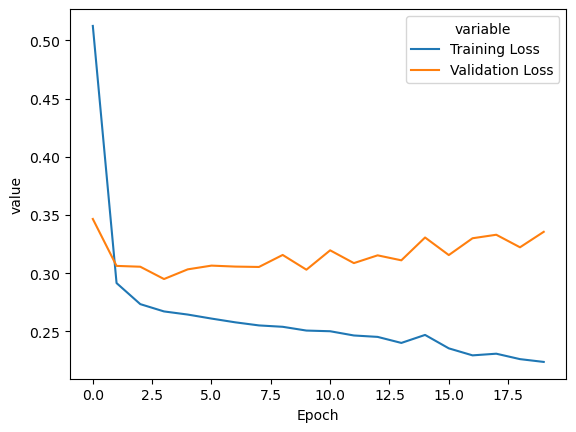

In [25]:
# Plot training curves
plot_data = pd.DataFrame(
    {
        "Epoch": [x for x in range(0,len(training_loss))],
        "Training Loss": training_loss,
        "Validation Loss": validation_loss
    }
)
sns.lineplot(x='Epoch', y='value', hue='variable', data=pd.melt(plot_data, ['Epoch']))

In [26]:
# Look at predictions
print(f"MAPE: {metrics.mean_absolute_percentage_error(labels, preds)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(labels, preds))}")
print(f"MAE: {metrics.mean_absolute_error(labels, preds)}")

MAPE: 0.17303071916103363
RMSE: 679.13720703125
MAE: 477.9693908691406
